# Preliminary Data Analysis

In [385]:
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt

In [386]:
training_set_location = "train.csv"
train_raw = pd.read_csv(training_set_location)

test_set_location = "test.csv"
test_raw = pd.read_csv(test_set_location)

train_raw.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We explain the columns of the dataset

- Survived if passenger survives
- PClass Ticket class = 1, 2, 3
- Sex = male/female
- Age = age in years, 0.5 if estimate
- Sibsp = siblings/spouses, Parch = parents/children
- ticket = ticket number
- Passenger fare
- Cabin number
- Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

/var/folders/lf/ln0gprpj0zv7llfsy7v5kwv40000gp/T/ipykernel_42223/3335545660.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = train_raw.groupby(age_bin)["Survived"].mean()


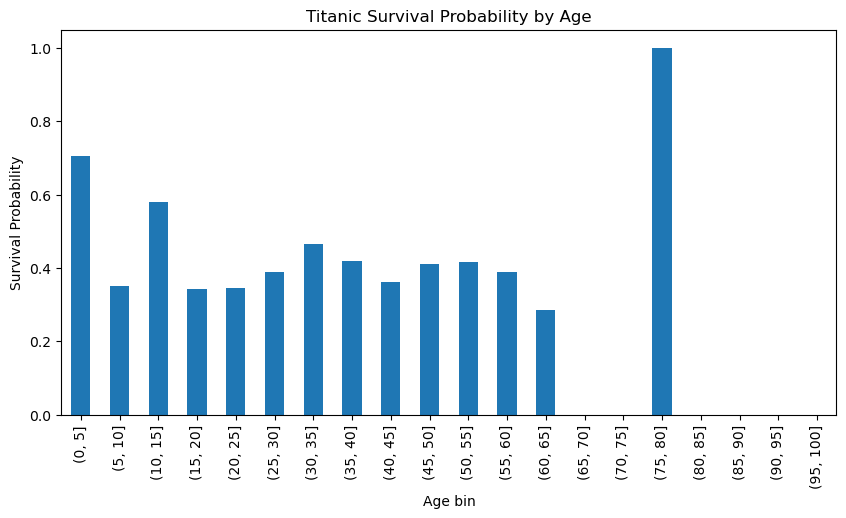

In [387]:
# Create age bins
bins = np.arange(0, 101, 5)  # 0-80 in 5-year bins
age_bin = pd.cut(train_raw["Age"], bins)

# Compute mean survival in each bin
age_survival = train_raw.groupby(age_bin)["Survived"].mean()

# Plot
age_survival.plot(kind="bar", figsize=(10, 5))
plt.ylabel("Survival Probability")
plt.xlabel("Age bin")
plt.title("Titanic Survival Probability by Age")
plt.show()

In [388]:
age_survival

Age
(0, 5]       0.704545
(5, 10]      0.350000
(10, 15]     0.578947
(15, 20]     0.343750
(20, 25]     0.344262
(25, 30]     0.388889
(30, 35]     0.465909
(35, 40]     0.417910
(40, 45]     0.361702
(45, 50]     0.410256
(50, 55]     0.416667
(55, 60]     0.388889
(60, 65]     0.285714
(65, 70]     0.000000
(70, 75]     0.000000
(75, 80]     1.000000
(80, 85]          NaN
(85, 90]          NaN
(90, 95]          NaN
(95, 100]         NaN
Name: Survived, dtype: float64

## Missing values
We analyze the missing values in the training data.

In [389]:
train_raw.notna().all() # the following code indicates that only Age, Cabin, and Embarked have missing values

PassengerId     True
Survived        True
Pclass          True
Name            True
Sex             True
Age            False
SibSp           True
Parch           True
Ticket          True
Fare            True
Cabin          False
Embarked       False
dtype: bool

In [390]:
print(f"Number of passengers without known age: {len(train_raw.loc[train_raw["Age"].isna()])} of {len(train_raw)}")
train_raw.loc[train_raw["Age"].isna()]

Number of passengers without known age: 177 of 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


The following code deals with the columns with NaNs

We now specify how we deal with missing values:
- We drop the cabin number, temporarily. This column isn't clean, some passengers have multiple.
- We impute the Age with the average age. We add a binary column, AgeKnown, if the age is exactly known.
- We create a new category for Embarked, M = missing

In [391]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = ["Age", "Fare", "SibSp", "Parch", "Fare"]# ["Fare", "SibSp", "Parch", "Fare"]
categorical_features = ["Sex", "Embarked", "AgeKnown"]

train_raw["AgeKnown"] = ((train_raw["Age"] % 1.0) == 0.0)|(train_raw["Age"] < 1.0)
test_raw["AgeKnown"] = ((test_raw["Age"] % 1.0) == 0.0)|(test_raw["Age"] < 1.0)

train_raw["Fare"] = np.log(1.0+train_raw["Fare"])
test_raw["Fare"] = np.log(1.0+test_raw["Fare"])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("polynomial", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Derived features
In this section, we add certain derived features

## Logistic Regression Model

In this section, we pass our transformed data through a logistic regression model to predict whether someone survived

In [392]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=10000))
])

X_train = train_raw.drop(columns=["PassengerId", "Survived", "Name", "Ticket", "Cabin"])
y_train = train_raw["Survived"]
X_test = test_raw.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

In [393]:
# k fold cross vlidation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

models = {f"Model C=10**{i}": Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=10000, C=10.0**i))
]) for i in np.arange(-2, 6)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5111)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"{name}: {scores.mean()}")

Model C=10**-2: 0.7340405498713201
Model C=10**-1: 0.8002385286548239
Model C=10**0: 0.8024982738057874
Model C=10**1: 0.80585022911305
Model C=10**2: 0.8058439520431862
Model C=10**3: 0.8058439520431862
Model C=10**4: 0.8058439520431862
Model C=10**5: 0.8058439520431862


In [394]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=10000, C=10.0))
])

clf.fit(X_train, y_train)

logreg = clf.named_steps["model"]
feature_names = clf.named_steps["preprocessor"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": logreg.coef_[0]
})
print(coef_df)



               feature  coefficient
0             num__Age    -1.159698
1            num__Fare     0.472926
2           num__SibSp    -0.933388
3           num__Parch     1.166908
4            num__Fare     0.472926
5           num__Age^2     0.419796
6        num__Age Fare     0.334283
7       num__Age SibSp     0.561544
8       num__Age Parch    -0.911200
9        num__Age Fare     0.334283
10         num__Fare^2    -0.120581
11     num__Fare SibSp     0.037245
12     num__Fare Parch    -0.269417
13      num__Fare Fare    -0.120581
14        num__SibSp^2    -1.093711
15    num__SibSp Parch     0.265861
16     num__SibSp Fare     0.037245
17        num__Parch^2    -0.166759
18     num__Parch Fare    -0.269417
19         num__Fare^2    -0.120581
20       cat__Sex_male    -2.593092
21     cat__Embarked_Q     0.118918
22     cat__Embarked_S    -0.353561
23  cat__AgeKnown_True     0.378372


In [ ]:
y_pred = pd.Series(clf.predict(X_test))
pred_df = pd.DataFrame({"PassengerId": test_raw["PassengerId"], "Survived": y_pred})
pred_df.to_csv("submission.csv", index=False)
pred_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Support Vector Machine

In [ ]:
numeric_features = ["Age", "Fare", "SibSp", "Parch", "Fare"]# ["Fare", "SibSp", "Parch", "Fare"]
categorical_features = ["Sex", "Embarked", "AgeKnown"]

train_raw["AgeKnown"] = ((train_raw["Age"] % 1.0) == 0.0)|(train_raw["Age"] < 1.0)
test_raw["AgeKnown"] = ((test_raw["Age"] % 1.0) == 0.0)|(test_raw["Age"] < 1.0)

train_raw["Fare"] = np.log(1.0+train_raw["Fare"])
test_raw["Fare"] = np.log(1.0+test_raw["Fare"])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    #("polynomial", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [451]:
from sklearn.svm import SVC

gamma_lo, gamma_hi = -6, 1
gamma_range = np.arange(gamma_lo, gamma_hi+1)
C_lo, C_hi = -1, 5
C_range = np.arange(C_lo, C_hi+1)

cvresults = np.zeros(shape=(gamma_range.size, C_range.size))

models = {(i,j): Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", SVC(kernel="rbf", gamma = 10.0**i, C=10.0**j, random_state=270502))
    ]) for i in np.arange(gamma_lo, gamma_hi+1) for j in np.arange(C_lo, C_hi+1)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5111)

for (i,j), model in models.items():
    cvresults[i-gamma_lo,j-C_lo] = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy").mean().round(2)

cvresults


array([[0.62, 0.62, 0.62, 0.62, 0.64, 0.79, 0.79],
       [0.62, 0.62, 0.62, 0.64, 0.79, 0.79, 0.79],
       [0.62, 0.62, 0.64, 0.79, 0.79, 0.79, 0.8 ],
       [0.62, 0.64, 0.79, 0.79, 0.79, 0.81, 0.82],
       [0.63, 0.79, 0.8 , 0.81, 0.82, 0.82, 0.79],
       [0.79, 0.82, 0.82, 0.8 , 0.78, 0.75, 0.75],
       [0.68, 0.81, 0.79, 0.77, 0.75, 0.75, 0.73],
       [0.62, 0.7 , 0.7 , 0.69, 0.67, 0.67, 0.66]])

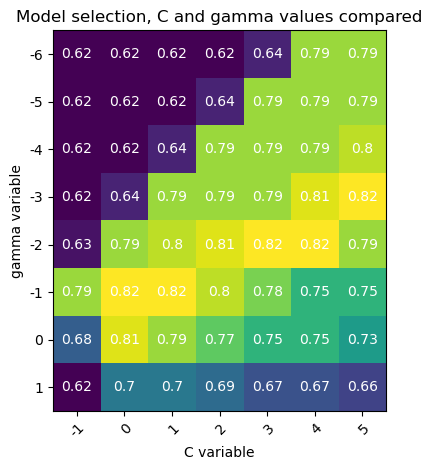

In [452]:
# plot results

fig, ax = plt.subplots()
im = ax.imshow(cvresults)

ax.set_xticks(range(len(C_range)), labels=C_range,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(gamma_range)), labels=gamma_range)

for i in range(len(gamma_range)):
    for j in range(len(C_range)):
        text = ax.text(j, i, cvresults[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Model selection, C and gamma values compared")

ax.set_xlabel("C variable")
ax.set_ylabel("gamma variable")
fig.tight_layout()
plt.show()

In [ ]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", SVC(kernel="rbf", gamma = 0.1, C=10.0, random_state=270502))
])

clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [414]:
y_pred = pd.Series(clf.predict(X_test))
pred_df = pd.DataFrame({"PassengerId": test_raw["PassengerId"], "Survived": y_pred})
pred_df.to_csv("submission.csv", index=False)
pred_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Submit Model

In [ ]:
# Uncomment code to submit model to kaggle

#!kaggle competitions submit -c titanic -f submission.csv -m "Logistic Regression Model with cubic numerics"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 7.52kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster